#  Comparative Analysis of Keras and PyTorch Models

### 1. Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

#General imports
import os 
import time 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

#sklearn imports
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.preprocessing import label_binarize

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu


### 2. Evaluation metrics 

The following metrics are used for evaluation of various AI/ML models:
    
- Accuracy
- Precision
- Recall
- F1 score
- Confusion matrix
- Receiver Operating Characteristic - Area Under Curve (ROC-AUC)

**1. Accuracy**

**Definition:**
Accuracy is the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined. In other words, it measures how often the classifier is correct overall.

**Formula:**
\[
Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
\]

- TP: True positives (correctly predicted positive cases)
- TN: True negatives (correctly predicted negative cases)
- FP: False positives (incorrectly predicted positive cases)
- FN: False negatives (incorrectly predicted negative cases)

**Significance:**

Accuracy is intuitive and easy to interpret, making it a common first metric for model evaluation. However, it can be misleading if the dataset is imbalanced (i.e., one class is much more frequent than the other). This is because a model can achieve high accuracy by simply predicting the majority class.


**2. Precision**

**Definition:**
Precision measures the proportion of positive predictions that are actually correct. It answers the question: "Of all the samples that the model predicted as positive, how many were truly positive?"

**Formula:**
\[
Precision = $\frac{TP}{TP + FP}$
\]

**Significance:**
Precision is crucial when the cost of a false positive is high. For example, in medical diagnosis, predicting a disease when it's not present (false positive) can lead to unnecessary treatments. In land classification, high precision means that when the model predicts a tile as agricultural, it is likely correct.


**3. Recall (sensitivity or true positive rate)**

**Definition:**
Recall measures the proportion of actual positive cases that were correctly identified by the model. It answers: "Of all the true positive samples, how many did the model identify?"

**Formula:**
\[
Recall = $\frac{TP}{TP + FN}$
\]

**Significance:**
Recall is important when the cost of missing a positive case (false negative) is high. In land classification, high recall means the model is good at finding all the agricultural land, even if it sometimes mislabels non-agricultural land as agricultural.


**4. F1 score**

**Definition:**
The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both concerns. It is especially useful when you need to find an equilibrium between precision and recall.

**Formula:**
\[
F1 = $2 \times \frac{Precision \times Recall}{Precision + Recall}$
\]

**Significance:**
The F1 score is especially valuable when the class distribution is uneven or when both false positives and false negatives are important. It penalizes extreme values, so a model with high precision but low recall (or vice versa) will have a lower F1 score.


**5. Confusion matrix**

**Definition:**
A confusion matrix is a table that summarizes the performance of a classification algorithm. It displays the counts of true positives, false positives, true negatives, and false negatives.

|               | Predicted positive | Predicted negative |
|---------------|-------------------|-------------------|
| Actual positive | True positive (TP) | False negative (FN) |
| Actual negative | False positive (FP) | True negative (TN) |

**Significance:**
The confusion matrix provides a detailed breakdown of model errors and successes, helping you understand not just how often the model is right, but *how* it is wrong. This is crucial for diagnosing issues like class imbalance or systematic misclassification.


**6. ROC-AUC (Receiver operating characteristic - Area under curve)**

**Definition:**
ROC-AUC measures the model's ability to distinguish between classes across all possible classification thresholds. The ROC curve plots the true positive rate (recall) against the false positive rate at various thresholds. The AUC (area under the curve) summarizes this performance in a single value between 0 and 1.

**Significance:**
A model with an ROC-AUC of 1.0 perfectly distinguishes between classes, while a value of 0.5 suggests random guessing. ROC-AUC is especially useful for imbalanced datasets and when you care about the ranking of predictions rather than their absolute values.



### 2.1 Function for evaluation metrics

In [3]:

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )


# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_auc_score(y_true, y_prob),
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()


### 3. Model and Dataset paths

In [4]:
data_dir = os.path.join(os.getcwd(), "..", "models")

keras_model_name = "cnn_model_keras_best.model.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

pytorch_state_dict_name = "cnn_pytorch_state_dict.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)



dataset_path = os.path.join(os.getcwd(), "..", "data", "images_dataSAT")
print(dataset_path)

img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
num_classes = 2

agri_class_labels = ["non-agri", "agri"]

/home/ashmin/Projects/land-classification-using-deep-learning/notebooks/../data/images_dataSAT


### 4. Keras model evaluation and prediction

Found 6000 images belonging to 2 classes.
Number of Steps: 47 with batch size: 128


Steps: 100%|██████████| 47/47 [00:13<00:00,  3.49it/s]

Evaluation metrics for the Keras Model
Accuracy:  0.9920
ROC-AUC:   1.0000
Loss:      0.0247

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9843    1.0000    0.9921      3000
        agri     1.0000    0.9840    0.9919      3000

    accuracy                         0.9920      6000
   macro avg     0.9921    0.9920    0.9920      6000
weighted avg     0.9921    0.9920    0.9920      6000

========= Confusion Matrix =========


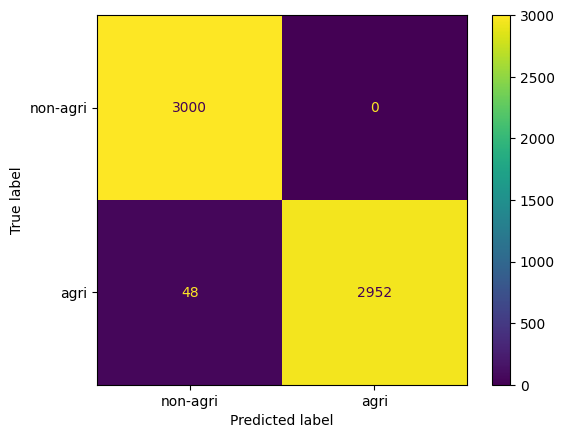

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

keras_model = tf.keras.models.load_model(keras_model_path)

steps = int(np.ceil(prediction_generator.samples / prediction_generator.batch_size))
batch_size = int(prediction_generator.batch_size)
print(f"Number of Steps: {steps} with batch size: {batch_size}")

all_preds_keras = []
all_probs_keras = []
all_labels_keras = []

for step_idx, step in enumerate(tqdm(range(steps), desc="Steps")):
    images, labels = next(prediction_generator)
    preds = keras_model.predict(images, verbose='0')
    all_probs_keras.extend(preds)
    preds = (preds > 0.5).astype(int).flatten()
    all_preds_keras.extend(preds)
    all_labels_keras.extend(labels)

print_metrics(y_true = all_labels_keras,
              y_pred = all_preds_keras,
              y_prob = all_probs_keras,
              class_labels = agri_class_labels,
              model_name = "Keras Model"
             )

### 5. PyTorch model evaluation and prediction

Processing inference on cpu
Created model, now loading the weights from saved model state dict
Loaded model state dict, now getting predictions


Step: 100%|██████████| 47/47 [00:18<00:00,  2.48it/s]

Evaluation metrics for the PyTorch Model
Accuracy:  0.9978
ROC-AUC:   1.0000
Loss:      0.0068

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9957    1.0000    0.9978      3000
        agri     1.0000    0.9957    0.9978      3000

    accuracy                         0.9978      6000
   macro avg     0.9978    0.9978    0.9978      6000
weighted avg     0.9978    0.9978    0.9978      6000

========= Confusion Matrix =========


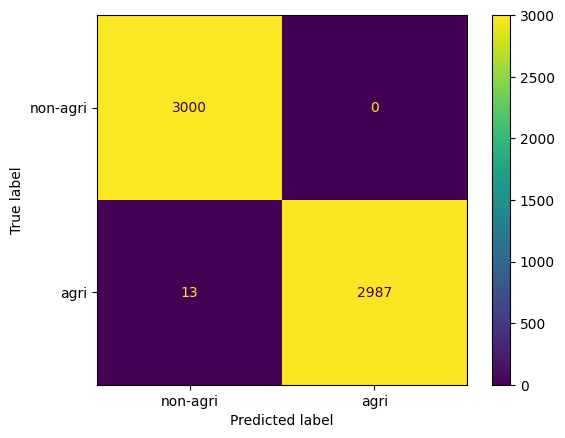

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Processing inference on {device}")

train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
    nn.MaxPool2d(2), nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
    nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    nn.AdaptiveAvgPool2d(1), nn.Flatten(),
    nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
    nn.Linear(2048, num_classes)
).to(device)

print("Created model, now loading the weights from saved model state dict")
model.load_state_dict(torch.load(pytorch_state_dict_path))
print("Loaded model state dict, now getting predictions")

all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []


model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = all_probs_pytorch,
              class_labels = agri_class_labels,
              model_name = "PyTorch Model"
             )

### 6. ROC curve plotting

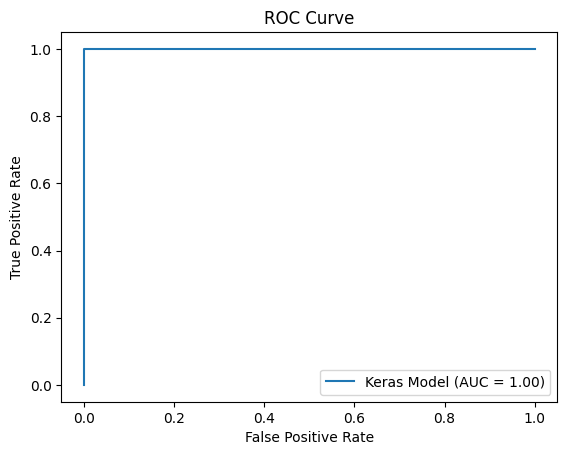

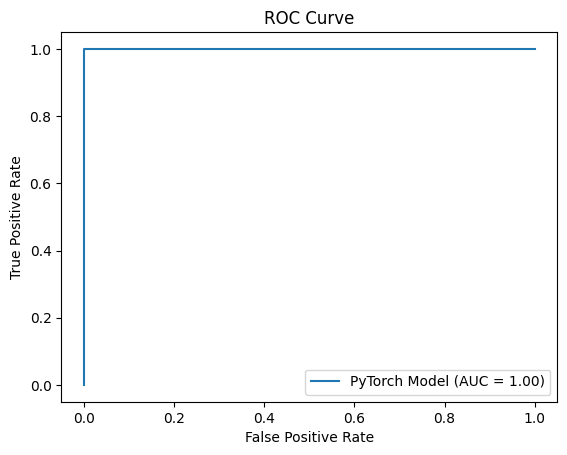

In [7]:

def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


plot_roc(np.array(all_labels_keras), np.array(all_probs_keras), "Keras Model")
plt.show()
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

###  Comparing model performance

In [8]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))

mertics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in mertics_list:
    print("{:<18} {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     Keras Model     PyTorch Model  
Accuracy   0.9920          0.9978         
Precision  1.0000          1.0000         
Recall     0.9840          0.9957         
F1 Score   0.9919          0.9978         
ROC-AUC    1.0000          1.0000         
